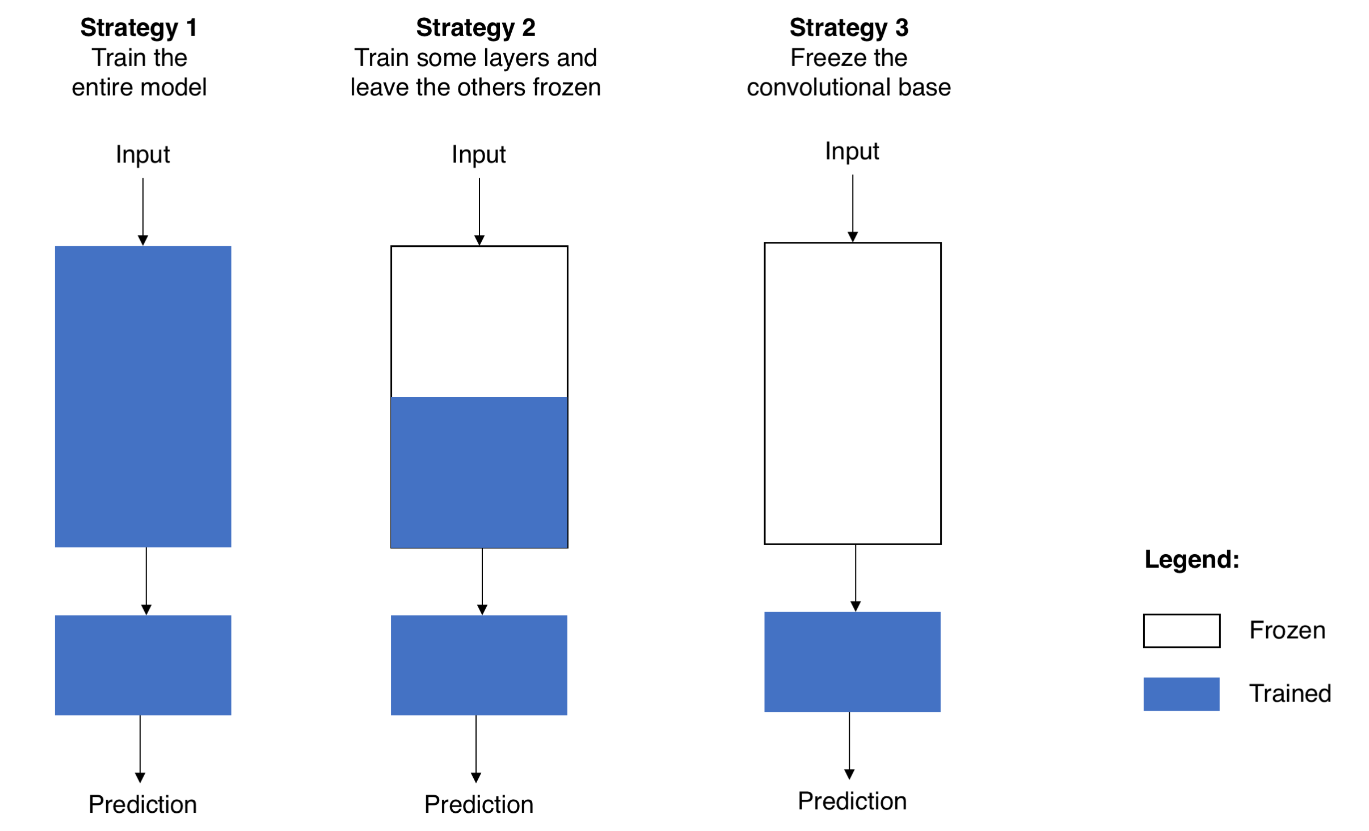

In [1]:
from IPython.display import Image
Image("strategies.png")

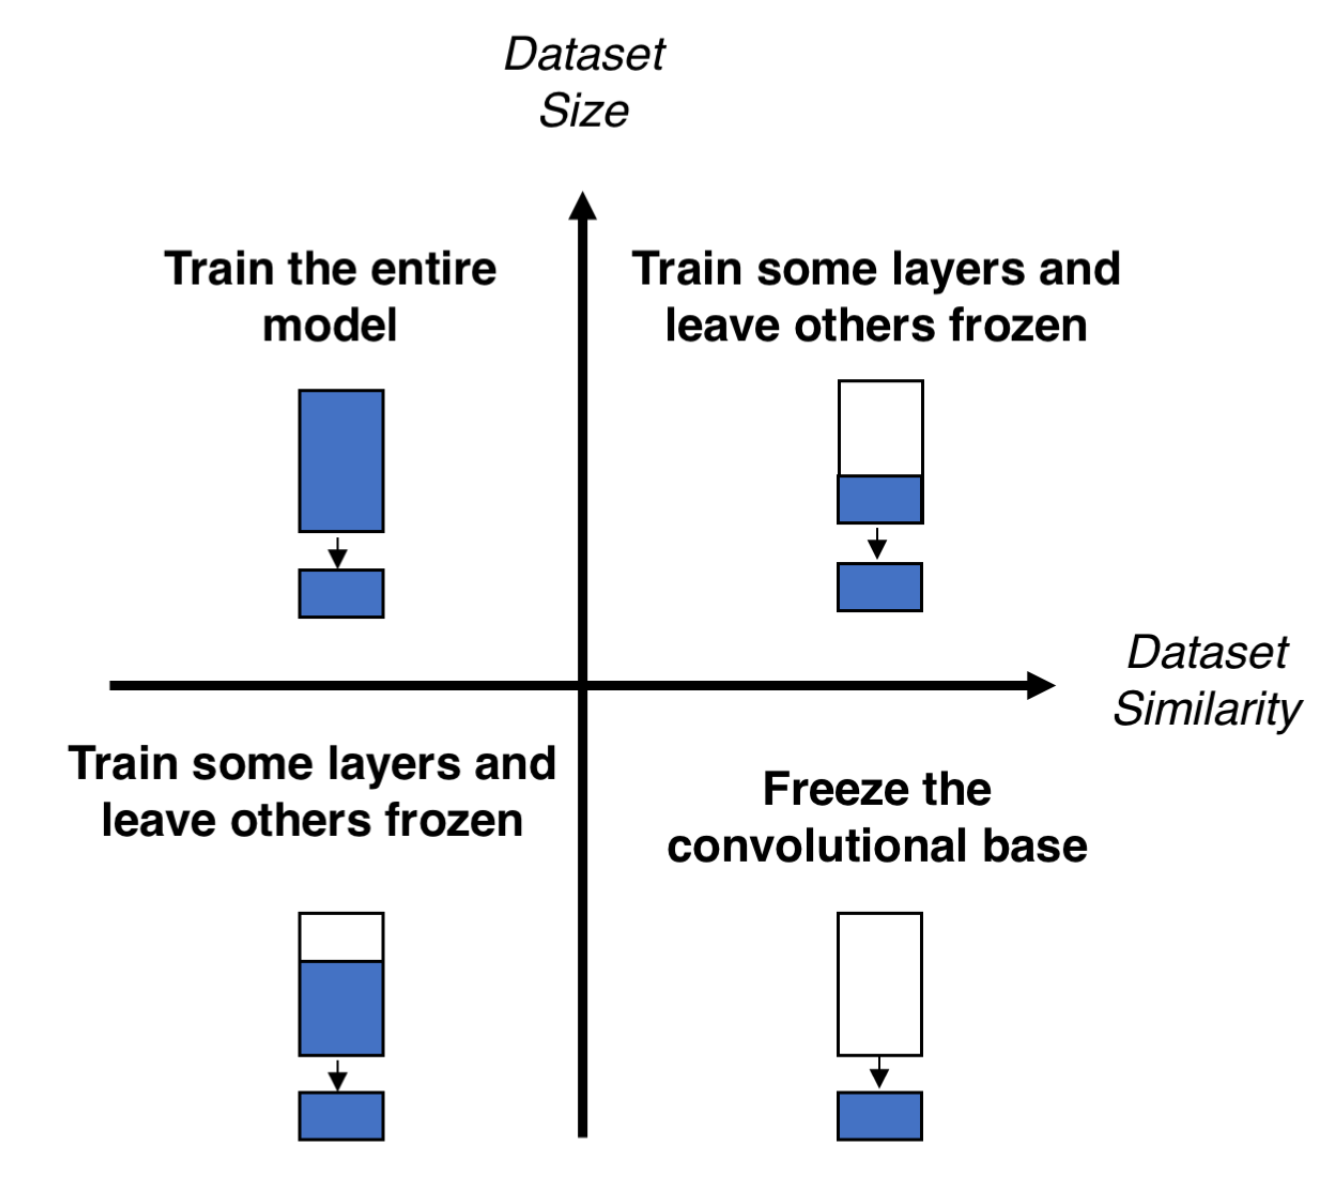

In [2]:
from IPython.display import Image
Image("approaches.png")

Here we will use feature extraction by extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

# The Convolutional Base (conv_base)

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for ResNet152V2 is 224, 224

In [4]:
# Instantiate convolutional base

from keras.applications.resnet_v2 import ResNet152V2

conv_base = ResNet152V2(include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        input_shape=(img_width, img_height, img_channels))

conv_base.summary()

Using TensorFlow backend.


Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [5]:
conv_base.output_shape

(None, 4, 4, 2048)

In [6]:
input_dim = conv_base.output_shape[1]*conv_base.output_shape[2]*conv_base.output_shape[3]

# Data preparation - Data augmentation

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All imgs will be resized to img_height x img_width
        target_size=(img_height, img_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


# Fully Connected Layers (FCL) classifier

## Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [8]:
# Define model

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) #help fighting overfitting
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 4, 4, 2048)        58331648  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 66,720,769
Trainable params: 66,577,025
Non-trainable params: 143,744
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 516


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 resnet152v2
1 flatten_1
2 dense_1
3 dropout_1
4 dense_2


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with data augmentation.

## Compile model

In [13]:
import pandas as pd

def info_layers(conv_base,model):
    
    list_layer_name = []
    list_trainable = []

    for layer in conv_base.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    

    df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    list_layer_name = []
    list_trainable = []

    for layer in model.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    
    df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    df2 = df2[1:]

    df= pd.concat([df1,df2])
    df.reset_index(drop=True,inplace=True)
    
    pd.options.display.max_rows = len(df)
    
    return df

In [14]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,conv1_pad,True
2,conv1_conv,True
3,pool1_pad,True
4,pool1_pool,True
5,conv2_block1_preact_bn,True
6,conv2_block1_preact_relu,True
7,conv2_block1_1_conv,True
8,conv2_block1_1_bn,True
9,conv2_block1_1_relu,True


In [15]:
# i = 0

# for layer in conv_base.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1
    
# for layer in model.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1

In [16]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [17]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-26 19:00:05.037367


In [18]:
# Train model
# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 582s 6s/step - loss: 0.9056 - acc: 0.6547 - val_loss: 0.6044 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 593s 6s/step - loss: 0.7530 - acc: 0.6855 - val_loss: 1.0981 - val_acc: 0.7500
Epoch 3/30
100/100 [==============================] - 586s 6s/step - loss: 0.6805 - acc: 0.7087 - val_loss: 0.9021 - val_acc: 0.7611
Epoch 4/30
100/100 [==============================] - 588s 6s/step - loss: 0.6366 - acc: 0.7320 - val_loss: 0.2274 - val_acc: 0.7734
Epoch 5/30
100/100 [==============================] - 588s 6s/step - loss: 0.6311 - acc: 0.7245 - val_loss: 0.4248 - val_acc: 0.7550
Epoch 6/30
100/100 [==============================] - 587s 6s/step - loss: 0.5902 - acc: 0.7451 - val_loss: 1.2352 - val_acc: 0.7632
Epoch 7/30
100/100 [==============================] - 588s 6s/step - loss: 0.6252 - acc: 0.7265 - val_loss: 0.5596 - val_acc: 0.7772


## Save model

In [19]:
model.save("../models/ResNet152V2_firebreak_detection_feature_extraction_data_augmentation_FC_model.h5")

## Model evaluation

### Learning curves

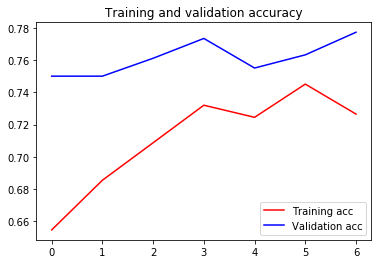

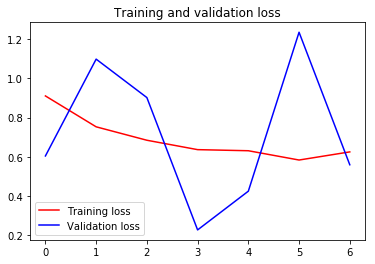

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/ResNet152V2_firebreak_detection_feature_extraction_data_augmentation_FC_history.csv", index = False)

In [22]:
t2 = datetime.datetime.now()
(print(t2))
print(t2-t1)

2019-11-26 20:08:44.991707
1:08:39.954340


### Model in action

In [23]:
def prediction_dataframe(generator):
    """ Generate dataframe with filename, probability, and class of the image
    """
    

    # Predict from generator (returns probabilities)
    pred=model.predict_generator(generator, steps=len(generator), verbose=1)

    # Get classes by np.round
    cl = np.round(pred)
    # Get filenames (set shuffle=false in generator is important)
    filenames=generator.filenames

    # Data frame
    results=pd.DataFrame({"file_name":filenames,"prob":pred[:,0], "class":cl[:,0]})
    results['file_name'] = results['file_name'].apply(lambda x: x.split('\\')[-1])
    
    return results

In [24]:
# obtaining predictions for test images

results = prediction_dataframe(test_generator)

32/32 [==============================] - 137s 4s/step


In [25]:
results.head()

,file_name,prob,class
0,2017-12-12 11-56-38_NAO.jpeg,0.268338,0.0
1,2018-01-09 16-17-15_NAO.jpeg,0.061385,0.0
2,2018-01-09 17-10-54_NAO.jpeg,0.061153,0.0
3,2018-01-30 08-53-00_NAO.jpeg,0.106143,0.0
4,2018-01-30 09-07-13_NAO.jpeg,0.170985,0.0


In [26]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases, results):
    """ shows images and prediction considering threshold of 0.5 and test images"""
    
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Make prediction
        
        idx = results.index[results['file_name'] == random_img].tolist()
        prediction = results['prob'].loc[idx[0]]

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

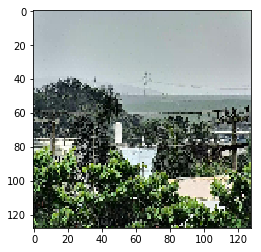

2018-01-30 10-47-37_SIM.jpeg
Not firebreack


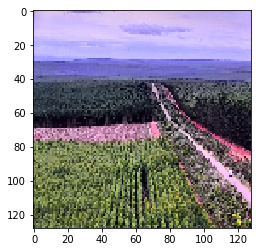

2018-10-29 16-10-13_SIM.jpeg
Not firebreack


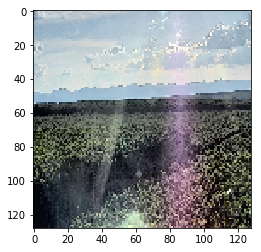

2018-03-15 17-20-00_NAO.jpeg
Not firebreack


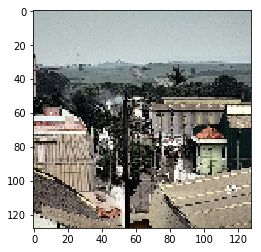

2018-01-10 11-08-21_SIM.jpeg
Not firebreack


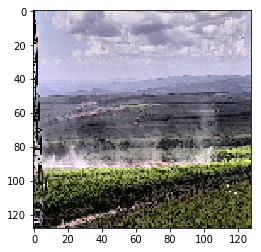

2018-03-16 12-42-23_NAO.jpeg
Not firebreack


In [27]:
# Visualize predictions
visualize_predictions(model, 5, results)

# Global average pooling

## Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [29]:
# Instantiate convolutional base

from keras.applications.resnet_v2 import ResNet152V2

conv_base = ResNet152V2(include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        input_shape=(img_width, img_height, img_channels))

conv_base.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [30]:
#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 58,333,697
Trainable params: 58,189,953
Non-trainable params: 143,744
_________________________________________________________________


In [31]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 514


In [32]:
conv_base.trainable = False

In [33]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [34]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 resnet152v2
1 global_average_pooling2d_1
2 dense_3


## Compile model

In [35]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,conv1_pad,True
2,conv1_conv,True
3,pool1_pad,True
4,pool1_pool,True
5,conv2_block1_preact_bn,True
6,conv2_block1_preact_relu,True
7,conv2_block1_1_conv,True
8,conv2_block1_1_bn,True
9,conv2_block1_1_relu,True


In [36]:
# # dataframe layers conv_base

# import pandas as pd
# pd.set_option('display.max_rows', -1)

# list_layer_name = []
# list_trainable = []

# for layer in conv_base.layers:
#     list_layer_name.append(layer.name)
#     list_trainable.append(layer.trainable)
    

# df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

# list_layer_name = []
# list_trainable = []

# for layer in model.layers:
#     list_layer_name.append(layer.name)
#     list_trainable.append(layer.trainable)
    

# df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

# df2 = df2[1:]

# df= pd.concat([df1,df2])
# df.reset_index(drop=True,inplace=True)
# df

In [37]:
# i = 0

# for layer in conv_base.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1
    
# for layer in model.layers:
#     sp = '      '[len(layer.name)-4:]
#     print(i,layer.name, sp, layer.trainable)
#     i+=1

In [38]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [39]:
# Train model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/100
100/100 [==============================] - 647s 6s/step - loss: 0.7409 - acc: 0.4912 - val_loss: 0.7514 - val_acc: 0.5141
Epoch 2/100
100/100 [==============================] - 657s 7s/step - loss: 0.6780 - acc: 0.5905 - val_loss: 0.9987 - val_acc: 0.5854
Epoch 3/100
100/100 [==============================] - 652s 7s/step - loss: 0.6384 - acc: 0.6618 - val_loss: 0.6349 - val_acc: 0.6310
Epoch 4/100
100/100 [==============================] - 653s 7s/step - loss: 0.6423 - acc: 0.6685 - val_loss: 0.5107 - val_acc: 0.6524
Epoch 5/100
100/100 [==============================] - 657s 7s/step - loss: 0.6037 - acc: 0.7065 - val_loss: 0.9972 - val_acc: 0.6522
Epoch 6/100
100/100 [==============================] - 669s 7s/step - loss: 0.6181 - acc: 0.7115 - val_loss: 0.5680 - val_acc: 0.6789
Epoch 7/100
100/100 [==============================] - 885s 9s/step - loss: 0.6182 - acc: 0.7102 - val_loss: 0.6691 - val_acc: 0.6794


## Save model

In [40]:
model.save("../models/ResNet152V2_firebreak_detection_feature_extraction_data_augmentation_GAP_model.h5")

# Model evaluation

## Learning curves

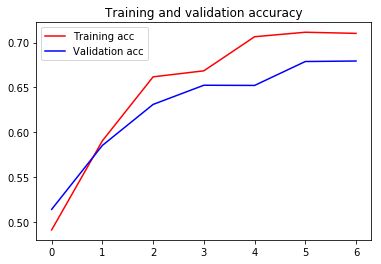

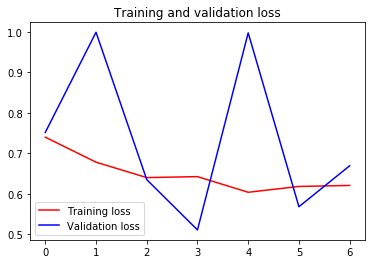

In [41]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/ResNet152V2_firebreak_detection_feature_extraction_data_augmentation_GAP_history.csv", index = False)

In [43]:
t3 = datetime.datetime.now()
(print(t3))
print(t3-t2)

2019-11-26 23:14:46.607211
3:06:01.615504


## Model in action

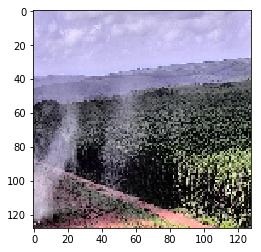

2018-03-16 09-33-49_NAO.jpeg
Not firebreack


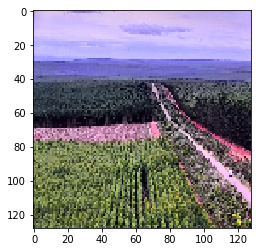

2018-10-29 16-10-13_SIM.jpeg
Not firebreack


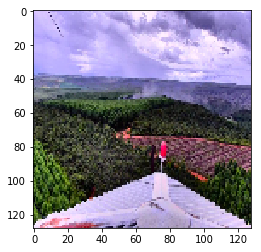

2019-02-07 15-08-05_NAO.jpeg
Not firebreack


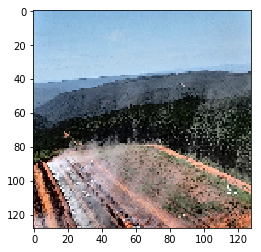

2018-03-21 10-10-06_SIM.jpeg
Not firebreack


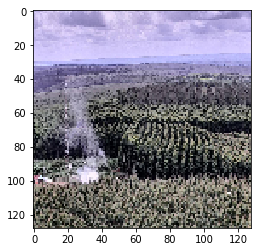

2018-03-17 11-01-28_SIM.jpeg
Not firebreack


In [44]:
# Visualize predictions
visualize_predictions(model, 5, results)

**REFERENCES:**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks